In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load the imputed dataset
print("Loading imputed dataset...")
df = pd.read_csv('imputed_original.csv')
print(f"Dataset shape: {df.shape}")

Loading imputed dataset...
Dataset shape: (2008, 40)


In [4]:
# Display the first few rows
print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
   verbal.response  eye.opening  movement  GCS  lactate.dehydrogenase  \
0                5            4         6   15             294.000000   
1                5            4         6   15             203.000000   
2                5            4         6   15             137.000000   
3                5            4         6   15             439.198029   
4                5            4         6   15             295.000000   

   glutamic.oxaloacetic.transaminase  globulin  total.bilirubin  \
0                          81.000000      23.8             18.3   
1                          21.000000      25.4             18.3   
2                           9.000000      27.7             11.9   
3                         261.453827      27.0             51.6   
4                          30.000000      29.6             11.8   

   direct.bilirubin  indirect.bilirubin  ...  eosinophil.ratio  \
0               6.9                11.4  ...             0.0

In [5]:
missing_values = df.isnull().sum().sum()
print(f"\nRemaining missing values in the dataset: {missing_values}")


Remaining missing values in the dataset: 0


In [6]:
target_col = 're.admission.within.6.months'
target_counts = df[target_col].value_counts()
print("\nTarget variable distribution:")
print(target_counts)
print(f"Class imbalance ratio: 1:{target_counts[0]/target_counts[1]:.2f}")


Target variable distribution:
re.admission.within.6.months
0    1235
1     773
Name: count, dtype: int64
Class imbalance ratio: 1:1.60


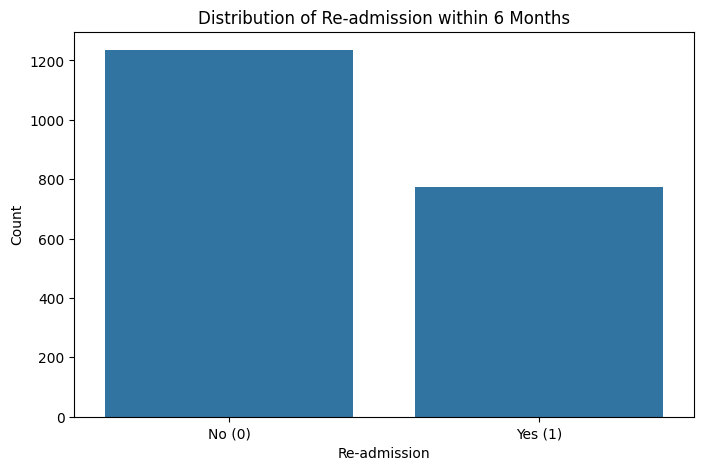

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=df)
plt.title('Distribution of Re-admission within 6 Months')
plt.xlabel('Re-admission')
plt.ylabel('Count')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.show()

In [8]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [9]:
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set class distribution: {Counter(y_train)}")
print(f"Test set class distribution: {Counter(y_test)}")



Training set shape: (1606, 39), Test set shape: (402, 39)
Training set class distribution: Counter({0: 988, 1: 618})
Test set class distribution: Counter({0: 247, 1: 155})


In [10]:
print("\nApplying SMOTE to training data...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set class distribution: {Counter(y_train_resampled)}")


Applying SMOTE to training data...
Resampled training set shape: (1976, 39)
Resampled training set class distribution: Counter({0: 988, 1: 988})


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
print("\nTraining Random Forest model...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=RANDOM_STATE
)



Training Random Forest model...


In [12]:
# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate metrics
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [13]:
# Print results
print("\nTest set evaluation:")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred))


Test set evaluation:
F1 Score: 0.4015

Confusion matrix:
[[183  64]
 [100  55]]

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       247
           1       0.46      0.35      0.40       155

    accuracy                           0.59       402
   macro avg       0.55      0.55      0.55       402
weighted avg       0.58      0.59      0.58       402



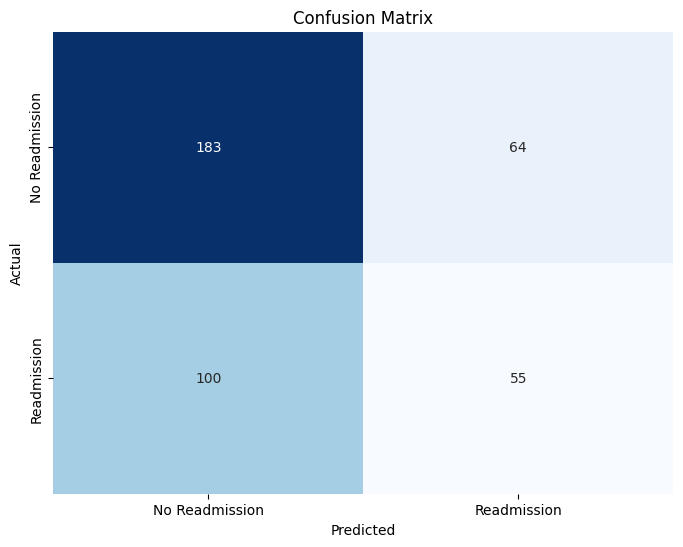

In [14]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['No Readmission', 'Readmission'])
plt.yticks([0.5, 1.5], ['No Readmission', 'Readmission'])
plt.show()



Analyzing feature importance...


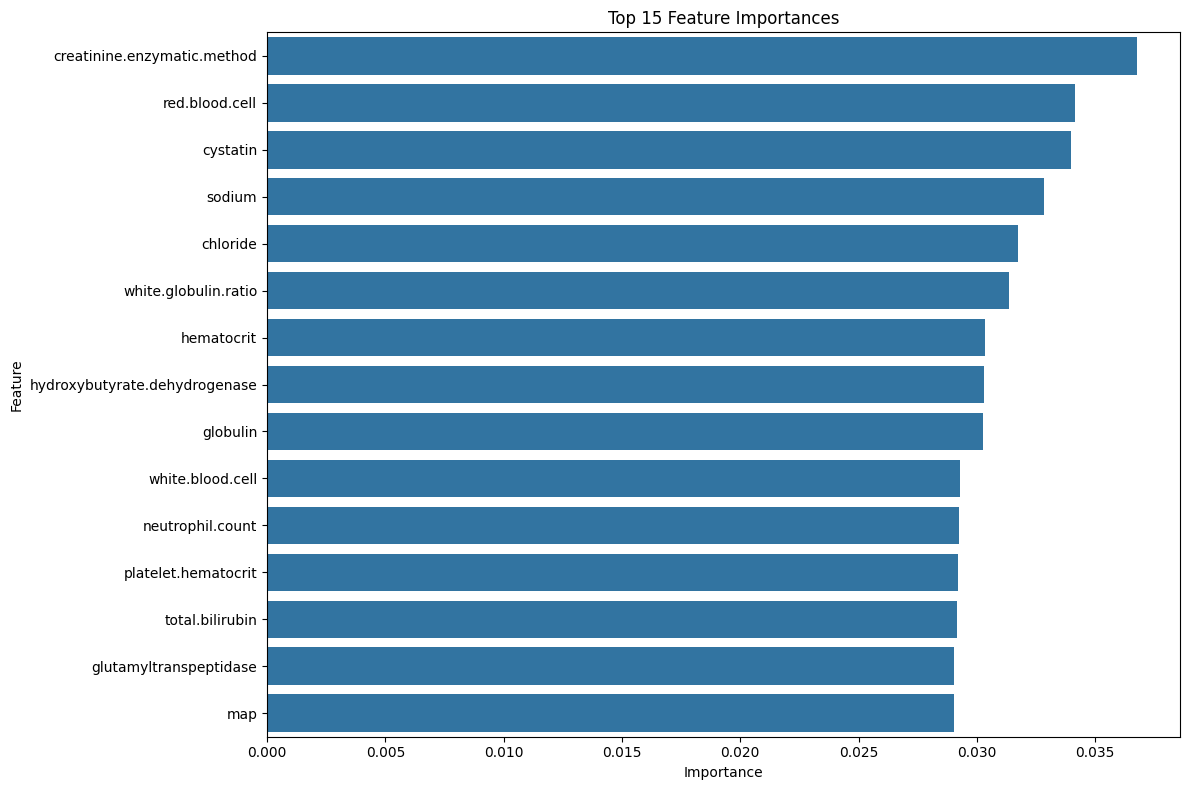

In [15]:
# Feature importance analysis
print("\nAnalyzing feature importance...")
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [16]:
print(feature_importance_df.head(15))

# Compare with published results
print("\nComparison with published results:")
print(f"Our Random Forest with SMOTE F1-Score: {f1:.4f}")
print("Published I-NAA F1-Score: 0.4799")
print("Published clinical baselines F1-Scores: ~0.45 (±0.02)")

                          Feature  Importance
34    creatinine.enzymatic.method    0.036745
12                 red.blood.cell    0.034139
35                       cystatin    0.033996
36                         sodium    0.032814
37                       chloride    0.031738
19           white.globulin.ratio    0.031356
11                     hematocrit    0.030342
14  hydroxybutyrate.dehydrogenase    0.030286
6                        globulin    0.030242
27               white.blood.cell    0.029292
26               neutrophil.count    0.029230
29            platelet.hematocrit    0.029200
7                 total.bilirubin    0.029144
17         glutamyltranspeptidase    0.029041
13                            map    0.029021

Comparison with published results:
Our Random Forest with SMOTE F1-Score: 0.4015
Published I-NAA F1-Score: 0.4799
Published clinical baselines F1-Scores: ~0.45 (±0.02)


In [17]:
test_predictions_df = X_test.copy()
test_predictions_df[target_col] = y_test.values
test_predictions_df['predicted_readmission'] = y_pred
test_predictions_df.to_csv('./data/test_predictions.csv', index=False)
print("\nTest set predictions saved to ./data/test_predictions.csv")


Test set predictions saved to ./data/test_predictions.csv


In [18]:
y_train_pred = model.predict(scaler.transform(X_train))
train_predictions_df = X_train.copy()
train_predictions_df[target_col] = y_train.values
train_predictions_df['predicted_readmission'] = y_train_pred
train_predictions_df.to_csv('./data/train_predictions.csv', index=False)
print("Training set predictions saved to ./data/train_predictions.csv")

Training set predictions saved to ./data/train_predictions.csv


In [19]:
print("\nGenerating predictions for the entire dataset...")
X_scaled_all = scaler.transform(X)
all_predictions = model.predict(X_scaled_all)

# Create a DataFrame with all predictions
all_predictions_df = df.copy()
all_predictions_df['predicted_readmission'] = all_predictions

# Save to CSV
all_predictions_df.to_csv('./data/all_predictions.csv', index=False)
print("All predictions saved to ./data/all_predictions.csv")


Generating predictions for the entire dataset...
All predictions saved to ./data/all_predictions.csv


In [20]:
import joblib
joblib.dump(model, './models/readmission_prediction_model.pkl')
print("Model saved to ./models/readmission_prediction_model.pkl")

# Save dataset indices for reference
train_test_indices = pd.DataFrame({
    'index': np.arange(len(df)),
    'set': ['train' if i in X_train.index else 'test' for i in range(len(df))]
})
train_test_indices.to_csv('./data/train_test_indices.csv', index=False)
print("Train/test indices saved to ./data/train_test_indices.csv")

Model saved to ./models/readmission_prediction_model.pkl
Train/test indices saved to ./data/train_test_indices.csv


## Evaluation

In [21]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score,
    confusion_matrix
)

In [22]:
def calculate_metrics(y_true, y_pred, y_prob=None):
    """
    Calculate and return comprehensive performance metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_prob: Predicted probabilities for positive class (if available)
        
    Returns:
        Dictionary of metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    
    # Confusion matrix elements
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Additional metrics
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # Class-specific metrics
    metrics['precision_class0'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    metrics['precision_class1'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall_class0'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['recall_class1'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # If probability scores are available, calculate AUC and average precision
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        metrics['avg_precision'] = average_precision_score(y_true, y_prob)
    
    return metrics


Metrics for train-test split approach (test set only):
Accuracy: 0.5920
Precision: 0.4622
Recall: 0.3548
F1 Score: 0.4015
Specificity: 0.7409
Negative Predictive Value: 0.6466
ROC AUC: 0.5834
Average Precision: 0.4900

Metrics saved to ./data/train_test_metrics.csv


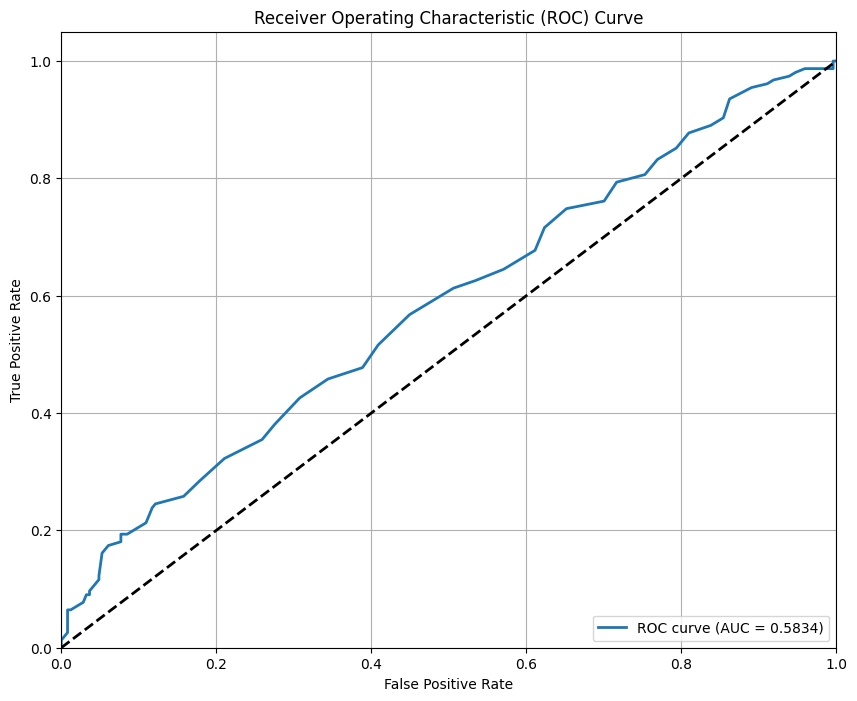

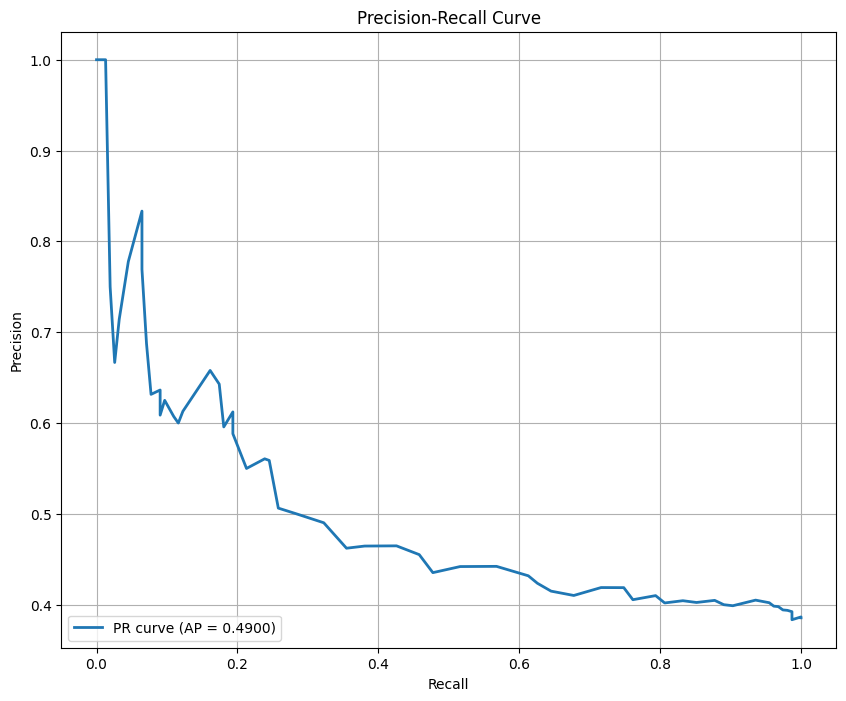

In [23]:
# For train-test split approach
if 'y_test' in locals() and 'y_pred' in locals():
    print("\nMetrics for train-test split approach (test set only):")
    # Check if we have predicted probabilities
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class
        metrics = calculate_metrics(y_test, y_pred, y_prob)
    else:
        metrics = calculate_metrics(y_test, y_pred)
    
    # Display metrics
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Negative Predictive Value: {metrics['npv']:.4f}")
    
    if 'roc_auc' in metrics:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
        print(f"Average Precision: {metrics['avg_precision']:.4f}")
    
    # Save metrics to CSV for easy comparison
    metrics_df = pd.DataFrame([metrics])
    metrics_df['method'] = 'Train-Test Split'
    metrics_df['dataset'] = 'Physionet Heart Failure'
    metrics_df.to_csv('./data/train_test_metrics.csv', index=False)
    print("\nMetrics saved to ./data/train_test_metrics.csv")
    
    # Plot ROC curve if probabilities are available
    if 'roc_auc' in metrics:
        from sklearn.metrics import roc_curve
        
        plt.figure(figsize=(10, 8))
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {metrics["roc_auc"]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig('./figures/roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot Precision-Recall curve
        plt.figure(figsize=(10, 8))
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {metrics["avg_precision"]:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.savefig('./figures/pr_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

In [24]:
# For cross-validation approach
if 'results' in locals() and 'y_test_combined' in locals() and 'y_pred_combined' in locals():
    print("\nMetrics for cross-validation approach (all folds combined):")
    
    # Calculate metrics on the combined predictions from all folds
    cv_metrics = calculate_metrics(y_test_combined, y_pred_combined)
    
    # Display metrics
    print(f"Accuracy: {cv_metrics['accuracy']:.4f}")
    print(f"Precision: {cv_metrics['precision']:.4f}")
    print(f"Recall: {cv_metrics['recall']:.4f}")
    print(f"F1 Score: {cv_metrics['f1']:.4f}")
    print(f"Specificity: {cv_metrics['specificity']:.4f}")
    print(f"Negative Predictive Value: {cv_metrics['npv']:.4f}")
    
    # Save metrics to CSV for easy comparison
    cv_metrics_df = pd.DataFrame([cv_metrics])
    cv_metrics_df['method'] = 'Cross-Validation'
    cv_metrics_df['dataset'] = 'Physionet Heart Failure'
    cv_metrics_df.to_csv('./data/cross_validation_metrics.csv', index=False)
    print("\nMetrics saved to ./data/cross_validation_metrics.csv")


In [25]:
# Compare with results from the research paper
paper_methods = [
    'Simple', 'kNN', 'MICE', 'MF', 'NAA', 'I-NAA', 'GAIN', 'I-GAIN'
]

paper_f1_scores = {
    'Simple': 0.4489,
    'kNN': 0.4567,
    'MICE': 0.4421,
    'MF': 0.4553,
    'NAA': 0.4632,
    'I-NAA': 0.4799,
    'GAIN': 0.4672,
    'I-GAIN': 0.4755
}



F1 Score Comparison with Research Paper Methods:
                 Method  F1 Score
6           Paper I-NAA   0.47990
8          Paper I-GAIN   0.47550
7            Paper GAIN   0.46720
5             Paper NAA   0.46320
2             Paper kNN   0.45670
4              Paper MF   0.45530
1          Paper Simple   0.44890
3            Paper MICE   0.44210
0  Our Train-Test Split   0.40146

F1 score comparison saved to ./data/f1_score_comparison.csv


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_5740\1065600611.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='F1 Score', data=comparison_df, palette=colors)


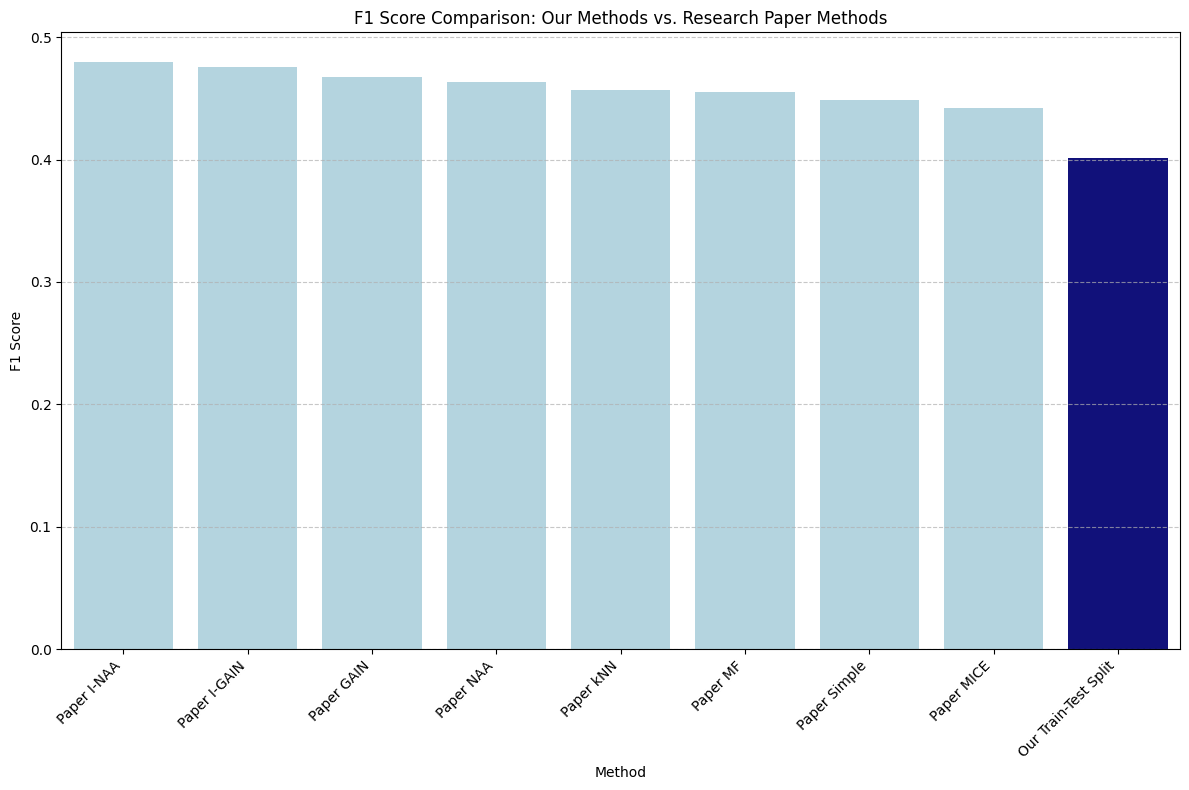

In [26]:
# Create a comparison dataframe
comparison_data = []

# Add our results
if 'metrics' in locals():
    comparison_data.append({
        'Method': 'Our Train-Test Split',
        'F1 Score': metrics['f1']
    })

if 'cv_metrics' in locals():
    comparison_data.append({
        'Method': 'Our Cross-Validation',
        'F1 Score': cv_metrics['f1']
    })

# Add paper results
for method in paper_methods:
    comparison_data.append({
        'Method': f'Paper {method}',
        'F1 Score': paper_f1_scores[method]
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by F1 score in descending order
comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

print("\nF1 Score Comparison with Research Paper Methods:")
print(comparison_df)

# Save comparison to CSV
comparison_df.to_csv('./data/f1_score_comparison.csv', index=False)
print("\nF1 score comparison saved to ./data/f1_score_comparison.csv")

# Visualize the comparison
plt.figure(figsize=(12, 8))
colors = ['darkblue' if 'Our' in method else 'lightblue' for method in comparison_df['Method']]
ax = sns.barplot(x='Method', y='F1 Score', data=comparison_df, palette=colors)
plt.title('F1 Score Comparison: Our Methods vs. Research Paper Methods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./figures/f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Statistical significance analysis (if cross-validation results are available)
if 'results' in locals() and 'f1_scores' in results:
    from scipy import stats
    
    print("\nStatistical Analysis of F1 Scores:")
    
    # Extract F1 scores from cross-validation
    cv_f1_scores = results['f1_scores']
    print(f"Our cross-validation F1 scores: {cv_f1_scores}")
    print(f"Mean: {np.mean(cv_f1_scores):.4f}, Std: {np.std(cv_f1_scores):.4f}")
    
    # Display confidence interval
    confidence = 0.95
    n = len(cv_f1_scores)
    mean = np.mean(cv_f1_scores)
    std_err = stats.sem(cv_f1_scores)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    
    print(f"{confidence*100:.1f}% Confidence Interval: {mean:.4f} ± {h:.4f} [{mean-h:.4f}, {mean+h:.4f}]")
    
    # Compare with the best method from the paper (I-NAA)
    best_paper_f1 = 0.4799  # I-NAA
    t_stat, p_value = stats.ttest_1samp(cv_f1_scores, best_paper_f1)
    
    print(f"Comparison with best paper method (I-NAA, F1={best_paper_f1}):")
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        if mean > best_paper_f1:
            print("Our method is significantly better than the best method in the paper (p < 0.05)")
        else:
            print("Our method is significantly worse than the best method in the paper (p < 0.05)")
    else:
        print("No significant difference between our method and the best method in the paper (p >= 0.05)")


In [28]:
summary_data = []

# Add our metrics
if 'metrics' in locals():
    our_tt_metrics = {
        'Method': 'Our Train-Test Split',
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1'],
        'Specificity': metrics['specificity'],
        'NPV': metrics['npv']
    }
    if 'roc_auc' in metrics:
        our_tt_metrics['ROC AUC'] = metrics['roc_auc']
        our_tt_metrics['Avg Precision'] = metrics['avg_precision']
    
    summary_data.append(our_tt_metrics)

if 'cv_metrics' in locals():
    our_cv_metrics = {
        'Method': 'Our Cross-Validation',
        'Accuracy': cv_metrics['accuracy'],
        'Precision': cv_metrics['precision'],
        'Recall': cv_metrics['recall'],
        'F1 Score': cv_metrics['f1'],
        'Specificity': cv_metrics['specificity'],
        'NPV': cv_metrics['npv']
    }
    summary_data.append(our_cv_metrics)

In [29]:
# Add paper results (we only have F1 scores)
for method in paper_methods:
    paper_metrics = {
        'Method': f'Paper {method}',
        'F1 Score': paper_f1_scores[method]
    }
    summary_data.append(paper_metrics)

# Create summary dataframe
summary_df = pd.DataFrame(summary_data)

# Save summary to CSV
summary_df.to_csv('./data/comprehensive_metrics_summary.csv', index=False)
print("Comprehensive metrics summary saved to ./data/comprehensive_metrics_summary.csv")

# Display summary table
print("\nComprehensive Metrics Summary:")
print(summary_df.to_string())

print("\nAnalysis complete. All metrics and comparisons have been calculated and saved.")

Comprehensive metrics summary saved to ./data/comprehensive_metrics_summary.csv

Comprehensive Metrics Summary:
                 Method  Accuracy  Precision    Recall  F1 Score  Specificity       NPV   ROC AUC  Avg Precision
0  Our Train-Test Split   0.59204   0.462185  0.354839   0.40146     0.740891  0.646643  0.583388       0.489956
1          Paper Simple       NaN        NaN       NaN   0.44890          NaN       NaN       NaN            NaN
2             Paper kNN       NaN        NaN       NaN   0.45670          NaN       NaN       NaN            NaN
3            Paper MICE       NaN        NaN       NaN   0.44210          NaN       NaN       NaN            NaN
4              Paper MF       NaN        NaN       NaN   0.45530          NaN       NaN       NaN            NaN
5             Paper NAA       NaN        NaN       NaN   0.46320          NaN       NaN       NaN            NaN
6           Paper I-NAA       NaN        NaN       NaN   0.47990          NaN       NaN       NaN

In [30]:
def visualize_metrics_dashboard(y_true, y_pred, y_prob=None, title_prefix="Model"):
    """
    Create a comprehensive dashboard of metrics visualizations
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_prob: Predicted probabilities for positive class (optional)
        title_prefix: Prefix to add to plot titles
    """
    # Calculate all metrics
    metrics_dict = calculate_metrics(y_true, y_pred, y_prob)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix with percentages (top left)
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{title_prefix} Confusion Matrix')
    ax1.set_xticklabels(['No Readmission', 'Readmission'])
    ax1.set_yticklabels(['No Readmission', 'Readmission'])
    
    # 2. Metrics Bar Chart (top middle)
    ax2 = plt.subplot2grid((2, 3), (0, 1))
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'specificity']
    values = [metrics_dict[m] for m in metrics_to_plot]
    colors = sns.color_palette("viridis", len(metrics_to_plot))
    bars = ax2.bar(metrics_to_plot, values, color=colors)
    ax2.set_ylim(0, 1.0)
    ax2.set_title(f'{title_prefix} Performance Metrics')
    ax2.set_ylabel('Score')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    # 3. Class-specific metrics (top right)
    ax3 = plt.subplot2grid((2, 3), (0, 2))
    class_metrics = [
        ('No Readmission\nPrecision', metrics_dict['precision_class0']),
        ('No Readmission\nRecall', metrics_dict['recall_class0']),
        ('Readmission\nPrecision', metrics_dict['precision_class1']),
        ('Readmission\nRecall', metrics_dict['recall_class1'])
    ]
    
    x_labels = [m[0] for m in class_metrics]
    values = [m[1] for m in class_metrics]
    colors = [colors[0], colors[1], colors[2], colors[3]]
    bars = ax3.bar(x_labels, values, color=colors)
    ax3.set_ylim(0, 1.0)
    ax3.set_title(f'{title_prefix} Class-Specific Metrics')
    ax3.set_ylabel('Score')
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    # 4. ROC Curve (bottom left)
    ax4 = plt.subplot2grid((2, 3), (1, 0))
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = metrics_dict.get('roc_auc', roc_auc_score(y_true, y_prob))
        ax4.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax4.plot([0, 1], [0, 1], 'k--', lw=2)
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title(f'{title_prefix} ROC Curve')
        ax4.legend(loc="lower right")
        ax4.grid(True)
    else:
        ax4.text(0.5, 0.5, 'Probability scores not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax4.transAxes)
        ax4.set_title('ROC Curve (Not Available)')
    
    # 5. Precision-Recall Curve (bottom middle)
    ax5 = plt.subplot2grid((2, 3), (1, 1))
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        avg_precision = metrics_dict.get('avg_precision', average_precision_score(y_true, y_prob))
        ax5.plot(recall, precision, lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
        ax5.set_xlabel('Recall')
        ax5.set_ylabel('Precision')
        ax5.set_title(f'{title_prefix} Precision-Recall Curve')
        ax5.legend(loc="lower left")
        ax5.grid(True)
    else:
        ax5.text(0.5, 0.5, 'Probability scores not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax5.transAxes)
        ax5.set_title('Precision-Recall Curve (Not Available)')
    
    # 6. Metrics Table (bottom right)
    ax6 = plt.subplot2grid((2, 3), (1, 2))
    ax6.axis('tight')
    ax6.axis('off')
    
    metrics_table = [
        ['Metric', 'Score'],
        ['Accuracy', f"{metrics_dict['accuracy']:.4f}"],
        ['Precision', f"{metrics_dict['precision']:.4f}"],
        ['Recall', f"{metrics_dict['recall']:.4f}"],
        ['F1 Score', f"{metrics_dict['f1']:.4f}"],
        ['Specificity', f"{metrics_dict['specificity']:.4f}"],
        ['NPV', f"{metrics_dict['npv']:.4f}"]
    ]
    
    if 'roc_auc' in metrics_dict:
        metrics_table.append(['ROC AUC', f"{metrics_dict['roc_auc']:.4f}"])
        metrics_table.append(['Avg Precision', f"{metrics_dict['avg_precision']:.4f}"])
    
    table = ax6.table(cellText=metrics_table, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    # Adjust the plot layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Return metrics and figure for saving
    return metrics_dict, fig

Loaded test predictions with 402 samples
Loaded the model successfully
Successfully calculated probability scores

===== Random Forest (Test Set) Performance Metrics =====
Accuracy:   0.5920
Precision:  0.4622
Recall:     0.3548
F1 Score:   0.4015
Specificity: 0.7409
NPV:        0.6466
ROC AUC:    0.4867
Avg Precision: 0.3902

Confusion Matrix:
[[183 64]
 [100 55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       247
           1       0.46      0.35      0.40       155

    accuracy                           0.59       402
   macro avg       0.55      0.55      0.55       402
weighted avg       0.58      0.59      0.58       402


Metrics visualization saved to: ./figures/random_forest_(test_set)_metrics_dashboard.png
Detailed metrics saved to: ./data/random_forest_(test_set)_detailed_metrics.csv


C:\Users\wh1sper\AppData\Local\Temp\ipykernel_5740\1666288100.py:309: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=f'{metric.upper()} Score', data=comparison_df, palette=colors)


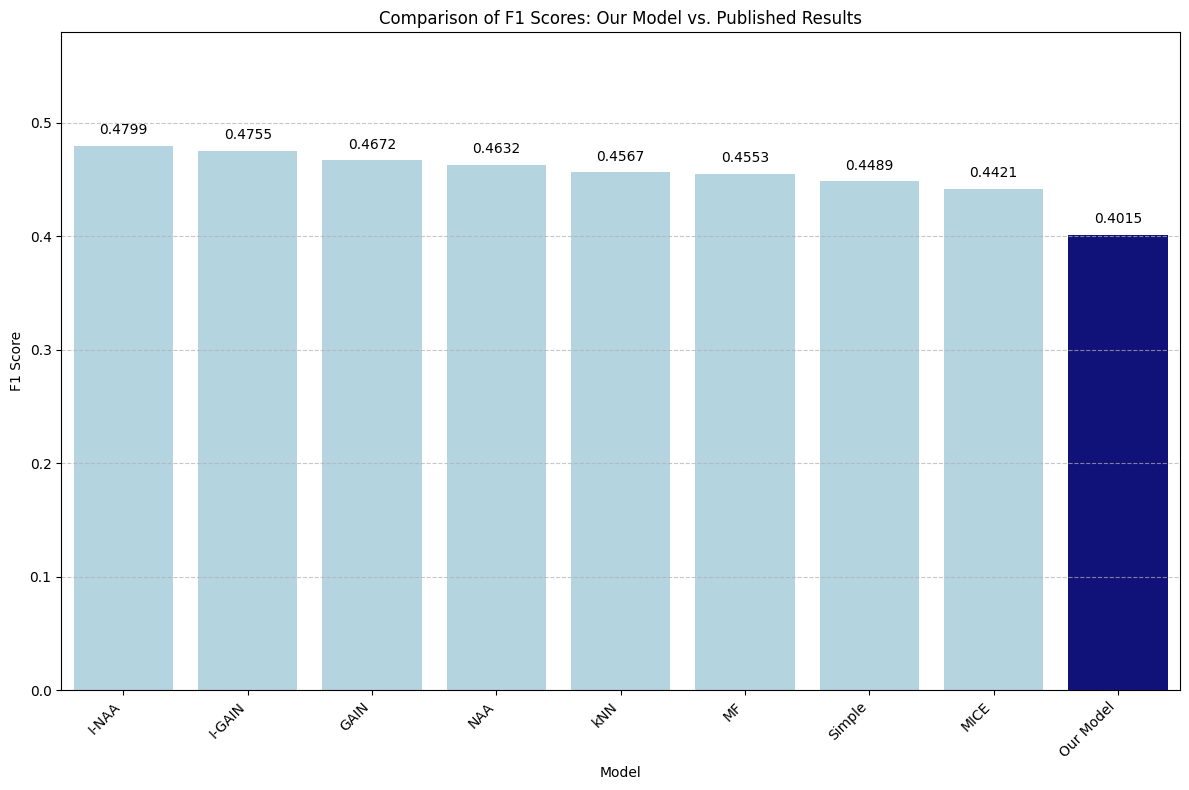


Model comparison saved to ./data/model_comparison_updated.csv

All visualizations complete!


: 

In [ ]:
# Execute Enhanced Metrics Visualization

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, roc_curve
)
import os

# Create directories if they don't exist
os.makedirs('./figures', exist_ok=True)
os.makedirs('./data', exist_ok=True)

# First, check if we have the y_test and y_pred variables by loading them
# You may need to adjust the paths if your files are stored differently
try:
    test_predictions_df = pd.read_csv('./data/test_predictions.csv')
    y_test = test_predictions_df['re.admission.within.6.months']
    y_pred = test_predictions_df['predicted_readmission']
    print(f"Loaded test predictions with {len(y_test)} samples")
except FileNotFoundError:
    print("Test predictions file not found. Make sure you've run the model training first.")
    # If you can't load from file, you could try to use variables in memory
    # This assumes you've already run the model in your notebook
    if 'y_test' not in locals() or 'y_pred' not in locals():
        print("y_test and y_pred variables not available. Please run the model training first.")
        exit(1)

# Define the calculate_metrics function
def calculate_metrics(y_true, y_pred, y_prob=None):
    """
    Calculate and return comprehensive performance metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_prob: Predicted probabilities for positive class (if available)
        
    Returns:
        Dictionary of metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    
    # Confusion matrix elements
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Additional metrics
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # Class-specific metrics
    metrics['precision_class0'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    metrics['precision_class1'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall_class0'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['recall_class1'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # If probability scores are available, calculate AUC and average precision
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        metrics['avg_precision'] = average_precision_score(y_true, y_prob)
    
    return metrics

# Improved Metrics Visualization
def visualize_metrics_dashboard(y_true, y_pred, y_prob=None, title_prefix="Model"):
    """
    Create a comprehensive dashboard of metrics visualizations
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_prob: Predicted probabilities for positive class (optional)
        title_prefix: Prefix to add to plot titles
    """
    # Calculate all metrics
    metrics_dict = calculate_metrics(y_true, y_pred, y_prob)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix with percentages (top left)
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{title_prefix} Confusion Matrix')
    ax1.set_xticklabels(['No Readmission', 'Readmission'])
    ax1.set_yticklabels(['No Readmission', 'Readmission'])
    
    # 2. Metrics Bar Chart (top middle)
    ax2 = plt.subplot2grid((2, 3), (0, 1))
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'specificity']
    values = [metrics_dict[m] for m in metrics_to_plot]
    colors = sns.color_palette("viridis", len(metrics_to_plot))
    bars = ax2.bar(metrics_to_plot, values, color=colors)
    ax2.set_ylim(0, 1.0)
    ax2.set_title(f'{title_prefix} Performance Metrics')
    ax2.set_ylabel('Score')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    # 3. Class-specific metrics (top right)
    ax3 = plt.subplot2grid((2, 3), (0, 2))
    class_metrics = [
        ('No Readmission\nPrecision', metrics_dict['precision_class0']),
        ('No Readmission\nRecall', metrics_dict['recall_class0']),
        ('Readmission\nPrecision', metrics_dict['precision_class1']),
        ('Readmission\nRecall', metrics_dict['recall_class1'])
    ]
    
    x_labels = [m[0] for m in class_metrics]
    values = [m[1] for m in class_metrics]
    colors = [colors[0], colors[1], colors[2], colors[3]]
    bars = ax3.bar(x_labels, values, color=colors)
    ax3.set_ylim(0, 1.0)
    ax3.set_title(f'{title_prefix} Class-Specific Metrics')
    ax3.set_ylabel('Score')
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')
    
    # 4. ROC Curve (bottom left)
    ax4 = plt.subplot2grid((2, 3), (1, 0))
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = metrics_dict.get('roc_auc', roc_auc_score(y_true, y_prob))
        ax4.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax4.plot([0, 1], [0, 1], 'k--', lw=2)
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title(f'{title_prefix} ROC Curve')
        ax4.legend(loc="lower right")
        ax4.grid(True)
    else:
        ax4.text(0.5, 0.5, 'Probability scores not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax4.transAxes)
        ax4.set_title('ROC Curve (Not Available)')
    
    # 5. Precision-Recall Curve (bottom middle)
    ax5 = plt.subplot2grid((2, 3), (1, 1))
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        avg_precision = metrics_dict.get('avg_precision', average_precision_score(y_true, y_prob))
        ax5.plot(recall, precision, lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
        ax5.set_xlabel('Recall')
        ax5.set_ylabel('Precision')
        ax5.set_title(f'{title_prefix} Precision-Recall Curve')
        ax5.legend(loc="lower left")
        ax5.grid(True)
    else:
        ax5.text(0.5, 0.5, 'Probability scores not available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax5.transAxes)
        ax5.set_title('Precision-Recall Curve (Not Available)')
    
    # 6. Metrics Table (bottom right)
    ax6 = plt.subplot2grid((2, 3), (1, 2))
    ax6.axis('tight')
    ax6.axis('off')
    
    metrics_table = [
        ['Metric', 'Score'],
        ['Accuracy', f"{metrics_dict['accuracy']:.4f}"],
        ['Precision', f"{metrics_dict['precision']:.4f}"],
        ['Recall', f"{metrics_dict['recall']:.4f}"],
        ['F1 Score', f"{metrics_dict['f1']:.4f}"],
        ['Specificity', f"{metrics_dict['specificity']:.4f}"],
        ['NPV', f"{metrics_dict['npv']:.4f}"]
    ]
    
    if 'roc_auc' in metrics_dict:
        metrics_table.append(['ROC AUC', f"{metrics_dict['roc_auc']:.4f}"])
        metrics_table.append(['Avg Precision', f"{metrics_dict['avg_precision']:.4f}"])
    
    table = ax6.table(cellText=metrics_table, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    # Adjust the plot layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Return metrics and figure for saving
    return metrics_dict, fig

# Create a comprehensive metrics report
def generate_metrics_report(y_true, y_pred, y_prob=None, model_name="Model"):
    """
    Generate and save a comprehensive metrics report
    
    Args:
        y_true: True labels
        y_pred: Predicted labels 
        y_prob: Predicted probabilities for positive class
        model_name: Name of the model for labeling
    
    Returns:
        Path to saved report
    """
    # Calculate and visualize metrics
    metrics, fig = visualize_metrics_dashboard(y_true, y_pred, y_prob, model_name)
    
    # Save the visualization
    fig_path = f'./figures/{model_name.lower().replace(" ", "_")}_metrics_dashboard.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Create a detailed metrics DataFrame
    metrics_df = pd.DataFrame([metrics])
    metrics_df['model_name'] = model_name
    
    # Save metrics to CSV
    csv_path = f'./data/{model_name.lower().replace(" ", "_")}_detailed_metrics.csv'
    metrics_df.to_csv(csv_path, index=False)
    
    # Print a summary
    print(f"\n===== {model_name} Performance Metrics =====")
    print(f"Accuracy:   {metrics['accuracy']:.4f}")
    print(f"Precision:  {metrics['precision']:.4f}")
    print(f"Recall:     {metrics['recall']:.4f}")
    print(f"F1 Score:   {metrics['f1']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"NPV:        {metrics['npv']:.4f}")
    
    if 'roc_auc' in metrics:
        print(f"ROC AUC:    {metrics['roc_auc']:.4f}")
        print(f"Avg Precision: {metrics['avg_precision']:.4f}")
    
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(f"[[{cm[0,0]} {cm[0,1]}]")
    print(f" [{cm[1,0]} {cm[1,1]}]]")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print(f"\nMetrics visualization saved to: {fig_path}")
    print(f"Detailed metrics saved to: {csv_path}")
    
    return metrics

# Function to compare our model with published results
def visualize_model_comparison(our_metrics, paper_metrics, metric='f1'):
    """
    Create a comparison visualization between our model and published results
    
    Args:
        our_metrics: Dictionary of our model metrics
        paper_metrics: Dictionary of paper models' metrics
        metric: Which metric to compare (default: f1)
    """
    # Combine metrics
    models = ['Our Model'] + list(paper_metrics.keys())
    values = [our_metrics[metric]] + [paper_metrics[m] for m in paper_metrics.keys()]
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': models,
        f'{metric.upper()} Score': values
    })
    
    # Sort by metric in descending order
    comparison_df = comparison_df.sort_values(f'{metric.upper()} Score', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    colors = ['darkblue' if 'Our' in model else 'lightblue' for model in comparison_df['Model']]
    ax = sns.barplot(x='Model', y=f'{metric.upper()} Score', data=comparison_df, palette=colors)
    
    # Add value labels
    for i, v in enumerate(comparison_df[f'{metric.upper()} Score']):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.title(f'Comparison of {metric.upper()} Scores: Our Model vs. Published Results')
    plt.xlabel('Model')
    plt.ylabel(f'{metric.upper()} Score')
    plt.ylim(0, max(values) + 0.1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save figure
    plt.savefig(f'./figures/model_comparison_{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return dataframe for further use
    return comparison_df

# Execute the code to generate the metrics report
# Try to load model probabilities if available
try:
    # Load the model first to get probability scores
    import joblib
    model = joblib.load('./models/readmission_prediction_model.pkl')
    print("Loaded the model successfully")
    
    # Now we need the test data to get probability scores
    try:
        # Try to load the test data features
        X_test = pd.read_csv('./data/train_test_indices.csv')
        X_test = X_test[X_test['set'] == 'test']
        
        # Get the original data and filter by test indices
        df = pd.read_csv('./data/imputed_original.csv')
        X_test_data = df.iloc[X_test.index]
        X_test_data = X_test_data.drop(columns=['re.admission.within.6.months'])
        
        # StandardScaler was used, so we need to transform the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_test_scaled = scaler.fit_transform(X_test_data)
        
        # Get probability scores
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        print("Successfully calculated probability scores")
        
        # Generate the report with probability scores
        test_metrics = generate_metrics_report(y_test, y_pred, y_prob, "Random Forest (Test Set)")
        
    except Exception as e:
        print(f"Could not load test data or calculate probabilities: {e}")
        print("Generating report without probability scores...")
        test_metrics = generate_metrics_report(y_test, y_pred, None, "Random Forest (Test Set)")
        
except Exception as e:
    print(f"Could not load the model: {e}")
    print("Generating report without probability scores...")
    test_metrics = generate_metrics_report(y_test, y_pred, None, "Random Forest (Test Set)")

# Compare with paper results
paper_f1_scores = {
    'Simple': 0.4489,
    'kNN': 0.4567,
    'MICE': 0.4421,
    'MF': 0.4553,
    'NAA': 0.4632,
    'I-NAA': 0.4799,
    'GAIN': 0.4672,
    'I-GAIN': 0.4755
}

comparison_df = visualize_model_comparison(test_metrics, paper_f1_scores, 'f1')
comparison_df.to_csv('./data/model_comparison_updated.csv', index=False)
print("\nModel comparison saved to ./data/model_comparison_updated.csv")
print("\nAll visualizations complete!")